<a href="https://colab.research.google.com/github/AliMadany/Deep-Learning-In-Computer-Vision-Models/blob/main/EM_Algorithm_for_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing neseccary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Using EM Algorithm Predefined

## Loading image


*   Parameters Initialization
*   Converting the colored image to a grey image



In [ ]:
image = cv2.imread("/content/Star-Fish-Kata-Noi-4.jpg")
image_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
height, width, channels = image_color.shape

pixels = image_color.reshape(-1, 3)

print("Feature matrix shape:", pixels.shape)

Feature matrix shape: (2800000, 3)


## EM algorithm pre-defined

*   Apply EM Algorithm Using Scikit-Learn (GaussianMixture).
*   Intializing the number of components in the GaussianMixture function to 2, since we want the foreground and background only.
*   Get cluster means (brightness level) average across RGB channels.
*   Find the label corresponding to the background (brightest cluster)
*   Generate binary mask, then invert the binary mask (foreground=1, background=0)
*   Finally, reshaping the mask to form the image.





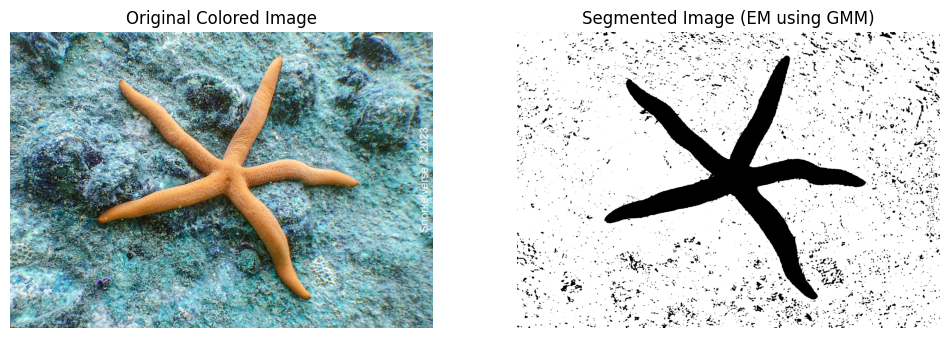

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(pixels)

labels = gmm.predict(pixels)

mean_clusters = gmm.means_.mean(axis=1)

background_label = np.argmax(mean_clusters)

binary_mask = (labels == background_label).astype(np.uint8)

binary_mask = 1 - binary_mask

segmented_image = binary_mask.reshape(height, width)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Colored Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap="gray")
plt.title("Segmented Image (EM using GMM)")
plt.axis("off")

plt.show()

# Using EM Algorithm from scratch

## A. Step 1

*   Load and preprocess image (resize & convert to RGB).
*   statistical distribution
*   stopping condition (maximum likelihood or maximum iteration)



In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
image_path = cv2.imread("/content/Star-Fish-Kata-Noi-4.jpg")

In [ ]:
def load_image(image_path, size=(256, 256)):

    image = cv2.imread(image_path)

    image = cv2.resize(image, size)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image_rgb, image_rgb.reshape(-1, 3)

In [ ]:
def initialize_gmm(K, D, seed=42):
    """Initialize Gaussian Mixture Model parameters randomly."""
    np.random.seed(seed)
    mu = np.random.randint(0, 255, (K, D))
    sigma = np.array([np.eye(D) * 100 for _ in range(K)])
    pi = np.ones(K) / K
    return mu, sigma, pi

## Expectation (E) Step

In [ ]:
def e_step(data, K, mu, sigma, pi):
    """Expectation Step: Compute responsibilities (gamma)."""
    N = data.shape[0]
    gamma = np.zeros((N, K))

    for k in range(K):
        gamma[:, k] = pi[k] * multivariate_normal.pdf(data, mean=mu[k], cov=sigma[k])

    gamma /= np.sum(gamma, axis=1, keepdims=True)  # Normalize
    return gamma

## Maximization (M) Step

In [ ]:
def m_step(data, gamma, K):
    """Maximization Step: Update GMM parameters."""
    N, D = data.shape
    Nk = np.sum(gamma, axis=0)
    pi = Nk / N

    mu = (gamma.T @ data) / Nk[:, np.newaxis]

    sigma = np.zeros((K, D, D))
    for k in range(K):
        diff = data - mu[k]

        #covariance update
        sigma[k] = (gamma[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]

    return mu, sigma, pi

## Function to compute log-likelihood to track convergence

In [ ]:
def compute_log_likelihood(data, K, mu, sigma, pi):
    """Compute log-likelihood to track convergence."""
    likelihoods = np.zeros((data.shape[0], K))

    for k in range(K):
        likelihoods[:, k] = pi[k] * multivariate_normal.pdf(data, mean=mu[k], cov=sigma[k])

    return np.sum(np.log(np.sum(likelihoods, axis=1)))

## EM Algorithm function

In [ ]:
def em_algorithm(data, K=2, max_iter=100, tolerance=1e-5):

    N, D = data.shape
    mu, sigma, pi = initialize_gmm(K, D)

    log_likelihood_prev = -np.inf

    for iteration in range(max_iter):
        gamma = e_step(data, K, mu, sigma, pi)
        mu, sigma, pi = m_step(data, gamma, K)
        log_likelihood = compute_log_likelihood(data, K, mu, sigma, pi)

        if np.abs(log_likelihood - log_likelihood_prev) < tolerance:
            break
        log_likelihood_prev = log_likelihood

    return gamma

## Functions to segment image and create binary masks



*   Segment image using the highest responsibility (gamma values), the reshaping back the image
*   Create binary masks for foreground and background



In [ ]:
def segment_image(image, gamma):
    """Segment image using the highest responsibility (gamma values)."""
    labels = np.argmax(gamma, axis=1)
    segmented_image = labels.reshape(image.shape[:2])
    return segmented_image

def create_masks(image_rgb, segmented_image):
    """Create binary masks for foreground and background."""
    foreground = np.zeros_like(image_rgb)
    background = np.zeros_like(image_rgb)

    foreground[segmented_image == 1] = image_rgb[segmented_image == 1]
    background[segmented_image == 0] = image_rgb[segmented_image == 0]

    return foreground, background

## Function to display the original, foreground, and background images.



In [ ]:
def display_results(image_rgb, foreground, background):

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(foreground)
    plt.title('Foreground')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(background)
    plt.title('Background')
    plt.axis('off')

    plt.show()

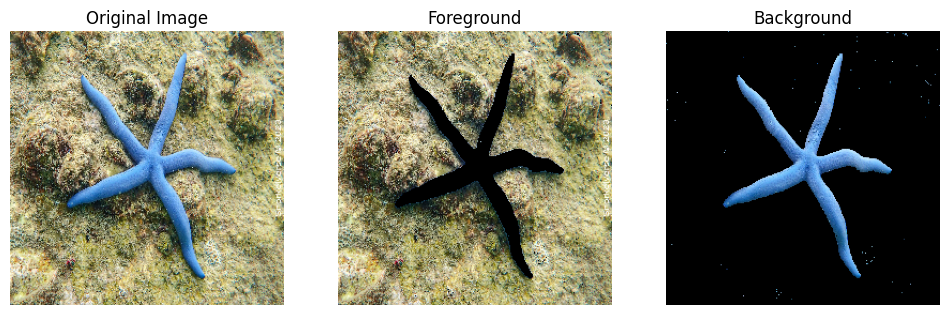

In [ ]:
image_rgb, data = load_image("/content/Star-Fish-Kata-Noi-4.jpg")

gamma = em_algorithm(data, K=2)
segmented_image = segment_image(image_rgb, gamma)
foreground, background = create_masks(image_rgb, segmented_image)

display_results(image_rgb, foreground, background)